In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle


seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear2D(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1, out_ring=False):
        super(BioLinear2D, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        
        #compute in_cor, shape: (in_dim_sqrt, in_dim_sqrt)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        in_dim_sqrt = int(np.sqrt(in_dim_fold))
        out_dim_sqrt = int(np.sqrt(out_dim_fold))
        x = np.linspace(1/(2*in_dim_sqrt), 1-1/(2*in_dim_sqrt), num=in_dim_sqrt)
        X, Y = np.meshgrid(x, x)
        self.in_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)
        
        # compute out_cor, shape: (out_dim_sqrt, out_dim_sqrt)
        if out_ring:
            thetas = np.linspace(1/(2*out_dim_fold)*2*np.pi, (1-1/(2*out_dim_fold))*2*np.pi, num=out_dim_fold)
            self.out_coordinates = 0.5+torch.tensor(np.transpose(np.array([np.cos(thetas), np.sin(thetas)]))/4, dtype=torch.float)
        else:
            x = np.linspace(1/(2*out_dim_sqrt), 1-1/(2*out_dim_sqrt), num=out_dim_sqrt)
            X, Y = np.meshgrid(x, x)
            self.out_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)

        
    def forward(self, x):
        return self.linear(x)
    

In [2]:
class BioMLP2D(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP2D, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth
                 
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1))
            elif i == self.depth - 1:
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1, out_ring=True))
            else:
                linear_list.append(BioLinear2D(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)
        
        
        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))
        
        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding

    def forward(self, x):
        shp = x.shape
        x = x.reshape(shp[0],-1)
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)
        
        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]
        
        return x
    
    def get_linear_layers(self):
        return self.linears
    
    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2)
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc
    
    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():  
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))
            
    def swap_bias(self, biases, j, k):
        with torch.no_grad():  
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp
    
    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron. 
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped. 
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            return
            # for images, do not allow input_perm
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm. do not allow input_perm for images
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index, score
    
    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)
            
    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id[0]:
            self.relocate_ij(i,j)
            
    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)
            
    


/home/thappek/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initial accuracy: 0.1010


  0%|          | 0/40000 [00:00<?, ?it/s]

torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 0/40000 [00:00<?, ?it/s]

0
20
40
60
80
0
20
40
60
80
0
20
40
60
80


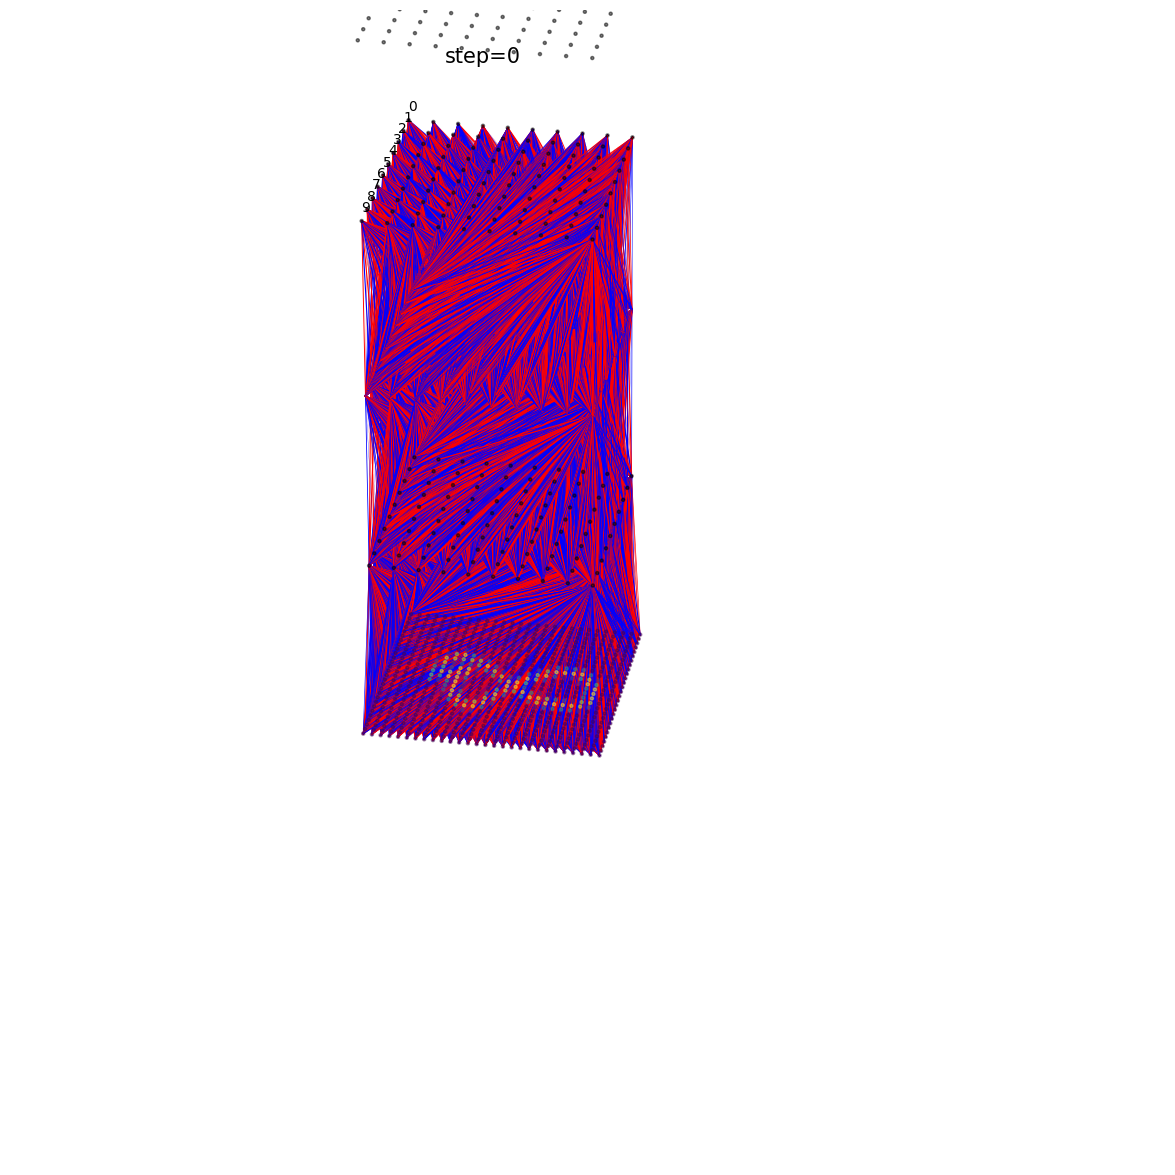

0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 8/40000 [01:12<54:46:45,  4.93s/it] 

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 20/40000 [01:12<14:13:09,  1.28s/it]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 38/40000 [01:12<4:22:13,  2.54it/s] 

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 61/40000 [01:12<1:38:20,  6.77it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 71/40000 [01:13<1:10:40,  9.42it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 81/40000 [01:13<50:47, 13.10it/s]  

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 90/40000 [01:13<42:03, 15.82it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 103/40000 [01:13<30:59, 21.46it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 124/40000 [01:13<16:44, 39.70it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 145/40000 [01:14<11:14, 59.13it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 166/40000 [01:14<09:00, 73.70it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 186/40000 [01:14<07:58, 83.28it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.102 | 0.105 | 0.968 | 0.968 | 0.441 :   0%|          | 196/40000 [01:14<07:52, 84.26it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 206/40000 [01:15<20:20, 32.61it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 224/40000 [01:15<14:11, 46.73it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 246/40000 [01:15<10:00, 66.24it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 267/40000 [01:16<08:21, 79.25it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 287/40000 [01:16<07:37, 86.88it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 297/40000 [01:16<10:20, 63.96it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 305/40000 [01:16<12:15, 53.98it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 325/40000 [01:16<09:27, 69.89it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 345/40000 [01:17<08:10, 80.87it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 364/40000 [01:17<07:36, 86.84it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 374/40000 [01:17<07:22, 89.45it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.905 | 0.915 | 0.190 | 0.194 | 0.436 :   1%|          | 393/40000 [01:17<09:46, 67.54it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 410/40000 [01:18<15:50, 41.67it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 429/40000 [01:18<11:25, 57.76it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 447/40000 [01:18<09:30, 69.37it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 458/40000 [01:19<08:33, 76.96it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 467/40000 [01:19<10:48, 60.97it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 482/40000 [01:19<13:06, 50.22it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 488/40000 [01:19<13:43, 48.01it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 499/40000 [01:20<15:11, 43.36it/s]

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


0.951 | 0.932 | 0.115 | 0.124 | 0.418 :   1%|          | 499/40000 [01:40<2:12:23,  4.97it/s]


KeyboardInterrupt: 

In [3]:
from itertools import islice
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from mpl_toolkits.mplot3d import Axes3D

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)


steps = 40000

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

device = "cuda:0" if torch.cuda.is_available() else "cpu"

train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)

def accuracy(network, dataset, device, N=2000, batch_size=50):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    correct = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        #print(x.shape)
        logits = network(x.to(device))
        predicted_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(predicted_labels == labels.to(device))
        total += x.size(0)
    return correct / total

def loss_f(network, dataset, device, N=2000, batch_size=50):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        logits = network(x.to(device))
        loss += torch.sum((logits-torch.eye(10,)[labels])**2)
        total += x.size(0)
    return loss / total

train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

data_size = 60000
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

def L2(model):
    L2_ = 0.
    for p in mlp.parameters():
        L2_ += torch.sum(p**2)
    return L2_

def rescale(model, alpha):
    for p in mlp.parameters():
        p.data = alpha * p.data


width = 200
mlp = BioMLP2D(shp=(784,100,100,100,100,10))


loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=0.0)

one_hots = torch.eye(10, 10).to(device)

mlp.eval()
print("Initial accuracy: {0:.4f}".format(accuracy(mlp, test, device)))

test_accuracies = []
train_accuracies = []

step = 0
mlp.train()
pbar = tqdm(islice(cycle(train_loader), steps), total=steps)

best_train_loss = 1e4
best_test_loss = 1e4
best_train_acc = 0.
best_test_acc = 0.

log = 200
lamb = 0.01
swap_log = 500
plot_log = 500



for x, label in pbar:
    
    if step == int(steps/4):
        lamb *= 10
    elif step == int(steps/2):
        lamb *= 10
    
    mlp.train()
    optimizer.zero_grad()
    print(x.size())
    loss_train = loss_fn(mlp(x.to(device)), one_hots[label])
    cc = mlp.get_cc(weight_factor=2.0, no_penalize_last=True)
    total_loss = loss_train + lamb*cc
    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        with torch.no_grad():
            mlp.eval()
            train_acc = accuracy(mlp, train, device).item()
            test_acc = accuracy(mlp, test, device).item()
            train_loss = loss_f(mlp, train, device).item()
            test_loss = loss_f(mlp, test, device).item()
            
            if train_acc > best_train_acc:
                best_train_acc = train_acc
            if test_acc > best_test_acc:
                best_test_acc = test_acc
            if train_loss < best_train_loss:
                best_train_loss = train_loss
            if test_loss < best_test_loss:
                best_test_loss = test_loss
            mlp.train()
            pbar.set_description("{:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} ".format(train_acc, test_acc, train_loss, test_loss, cc))
    step += 1

    if step % swap_log == 0:
        mlp.relocate()
        
    if (step-1) % plot_log == 0:
        
        fig=plt.figure(figsize=(30,15))
        ax=fig.add_subplot(projection='3d')

        ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
        ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
        ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
        ax.scatter(mlp.linears[3].in_coordinates[:,0].detach().numpy(), mlp.linears[3].in_coordinates[:,1].detach().numpy(),[3]*100, s=5, alpha=0.5, color="black")
        ax.scatter(mlp.linears[4].in_coordinates[:,0].detach().numpy(), mlp.linears[4].in_coordinates[:,1].detach().numpy(),[4]*100, s=5, alpha=0.5, color="black")
        ax.scatter(mlp.linears[4].out_coordinates[:,0].detach().numpy(), mlp.linears[4].out_coordinates[:,1].detach().numpy(),[5]*10, s=5, alpha=0.5, color="black")
        ax.set_zlim(-0.5,5)
        ax.set_xlim(-0.2,1.2)
        ax.set_ylim(-0.2,1.2)


        for ii in range(3):
            biolinear = mlp.linears[ii]
            p = biolinear.linear.weight.clone()
            p_shp = p.shape
            p = p/torch.abs(p).max()

            for i in range(p_shp[0]):
                if i % 20 == 0:
                    print(i)
                for j in range(p_shp[1]):
                    out_xy = biolinear.out_coordinates[i].detach().numpy()
                    in_xy = biolinear.in_coordinates[j].detach().numpy()
                    plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().numpy()), color="blue" if p[i,j]>0 else "red")


        ring = mlp.linears[2].out_coordinates.detach().numpy()
        for i in range(10):
            ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().numpy()))


        ax.view_init(30,10)

        ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

        ax.axis('off')
        
        plt.savefig('./results/mnist/{0:06d}.png'.format(step-1))
        
        plt.show()


In [ ]:
plt.figure(figsize=(6,3))

for i in range(1,3):
    top_k = 784
    linears = mlp.get_linear_layers()
    num_linear = len(linears)
    if i == 0:
        # input layer
        weights = linears[i].linear.weight
        score = torch.sum(torch.abs(weights), dim=0)
        in_fold = linears[0].in_fold
        #print(score.shape)
        score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
    elif i == num_linear:
        # output layer
        weights = linears[i-1].linear.weight
        score = torch.sum(torch.abs(weights), dim=1)
    else:
        weights_in = linears[i-1].linear.weight
        weights_out = linears[i].linear.weight
        score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
    #print(score.shape)
    top_index = torch.flip(torch.argsort(score),[0])[:top_k]
    score = score[top_index]
    
    num = score.shape[0]
    
    plt.plot(np.arange(num)+1, score.detach().numpy(), marker="o", markersize=3)
    
#plt.xscale('log')

plt.legend(["hidden layer 1", "hidden layer 2"], fontsize=15)
plt.xlabel("Rank", fontsize=15)
plt.ylabel("Score", fontsize=15)

i = 1
top_k = 784
linears = mlp.get_linear_layers()
num_linear = len(linears)
if i == 0:
    # input layer
    weights = linears[i].linear.weight
    score = torch.sum(torch.abs(weights), dim=0)
    in_fold = linears[0].in_fold
    #print(score.shape)
    score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
elif i == num_linear:
    # output layer
    weights = linears[i-1].linear.weight
    score = torch.sum(torch.abs(weights), dim=1)
else:
    weights_in = linears[i-1].linear.weight
    weights_out = linears[i].linear.weight
    score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
#print(score.shape)
top_index = torch.flip(torch.argsort(score),[0])[:top_k]
score = score[top_index]

num = score.shape[0]



In [ ]:
features = mlp.linears[0].linear.weight[top_index].reshape(100,28,28).detach().numpy()

In [ ]:
plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10,10,i+1)

    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("score=%.2f"%(score[i]), color="red", fontsize=15,y=0.8)
    
    
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("./fig/mnist_features.pdf", bbox_inches="tight")

In [ ]:
im_f2 = torch.argsort(mlp.linears[2].linear.weight[4])[-1]
im_f1 = torch.argsort(mlp.linears[1].linear.weight[im_f2,:])
features = mlp.linears[0].linear.weight[im_f1].reshape(100,28,28).detach().numpy()

In [ ]:
plt.figure(figsize=(20,20))

for i in range(100):
    plt.subplot(10,10,i+1)

    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title("weight=%.2f"%(mlp.linears[1].linear.weight[im_f2,im_f1[i]]), color="red", fontsize=15,y=0.8)
    
    
plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
plt.figure(figsize=(10,2))

nums = [2000,100,20]

for i in range(3):

    plt.subplot(1,3,i+1)

    weights = mlp.linears[i].linear.weight.reshape(-1,)
    weights = weights[torch.argsort(weights)]
    plt.plot(-weights[:nums[i]].detach().numpy(), marker="o", markersize=3)
    plt.plot(weights[-nums[i]:].detach().numpy()[::-1], marker="o", markersize=3)
    plt.xlabel("rank", fontsize=15)
    if i == 0:
        plt.ylabel("abs(weight)", fontsize=15)
        plt.legend(["positive", "negative"])
    plt.title("Layer {}".format(i+1))
    
    
#plt.savefig("./fig/mnist_weights.pdf", bbox_inches="tight")